=== EJERCICIO 3: INTERPRETABILIDAD Y MÉTRICAS AVANZADAS ===

PUNTO 1: Preprocesando dataset...
Dataset: 1682 películas, 19 géneros
Características: ['year', 'title_length', 'has_multiple_genres']

PUNTO 2: Dividiendo datos...
Entrenamiento: 1345 | Prueba: 337

PUNTO 3: Entrenando XGBoost multietiqueta...
Modelo entrenado ✓

PUNTO 4: Evaluando modelo...
F1-score Macro: 0.179
F1-score Micro: 0.316
Hamming Loss: 0.097

PUNTO 5: Aplicando SHAP y LIME...
Película analizada: Swept from the Sea (1997)
Géneros reales: ['Romance']
Géneros predichos: ['Comedy']

Aplicando SHAP para género 'unknown'...


/tmp/ipykernel_47339/1211155612.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


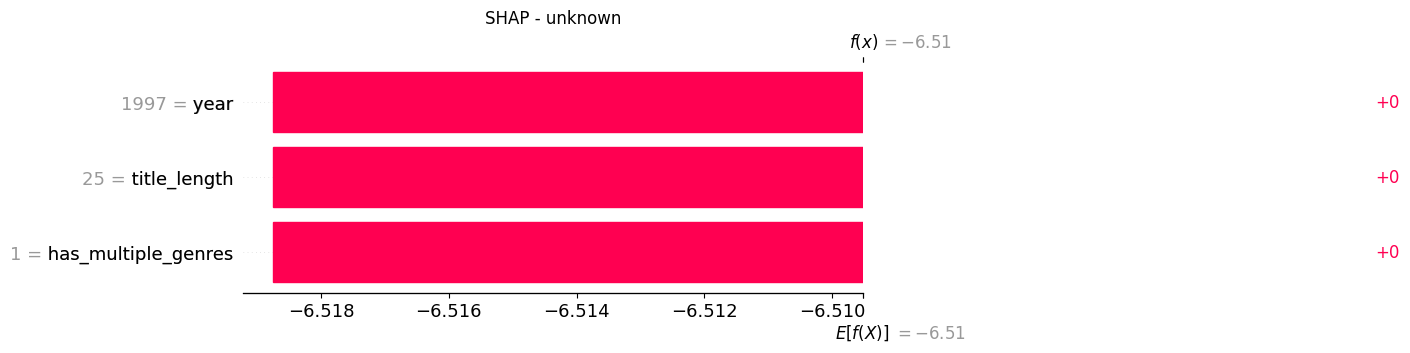

SHAP guardado: shap_analysis.png
Aplicando LIME...


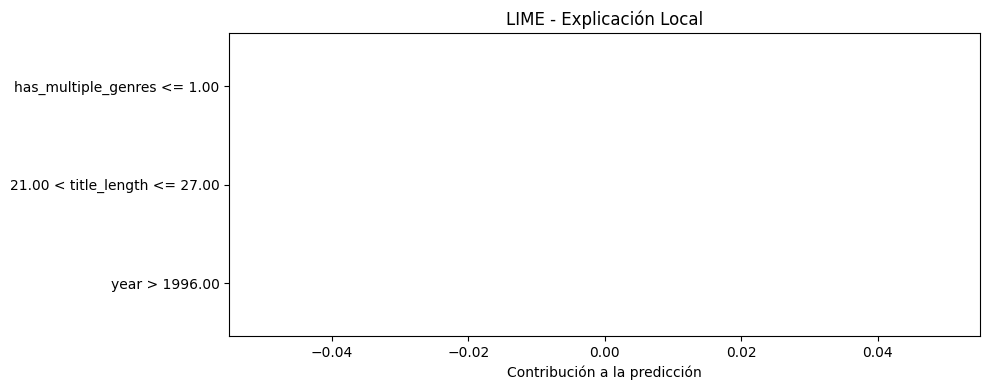

LIME guardado: lime_analysis.html

PUNTO 6: Top 5 características influyentes...


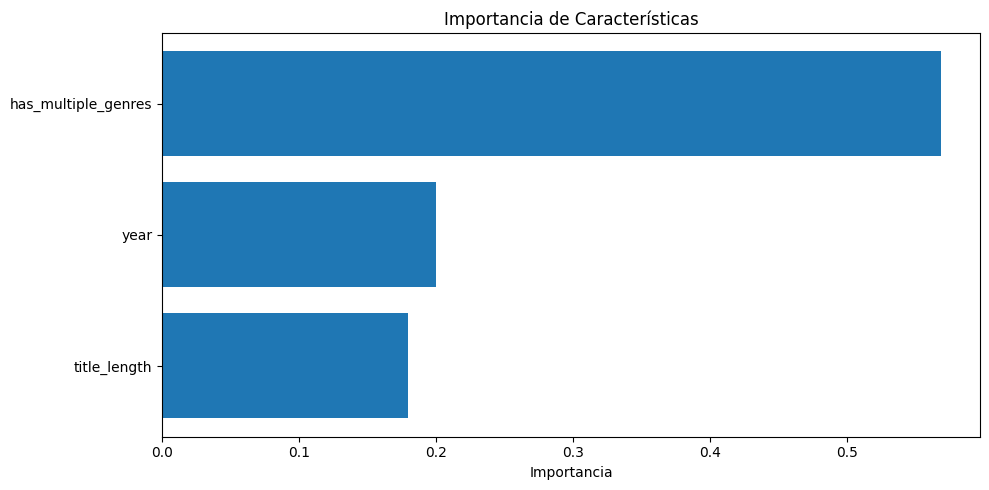

Importancia guardada: feature_importance.png

=== RESUMEN PARA ANÁLISIS ===
F1-Macro: 0.179 | F1-Micro: 0.316
Diferencia F1: 0.137
Hamming Loss: 0.097

Importancia de características:
  title_length: 0.179
  year: 0.200
  has_multiple_genres: 0.568

Ejemplo analizado:
  Película: Swept from the Sea (1997)
  Características: year=1997, title_length=25, multiple_genres=1

Archivos generados:
• shap_analysis.png - Análisis SHAP
• lime_analysis.html - Análisis LIME
• feature_importance.png - Importancia características

EJERCICIO COMPLETADO!


In [3]:
# ==============================================
# EJERCICIO 3: Interpretabilidad y Métricas Avanzadas (Nivel Avanzado)
# Objetivo: Clasificación multietiqueta con SHAP y LIME
# Dataset: MovieLens 100K
# ==============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, hamming_loss
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import lime
from lime import lime_tabular

print("=== EJERCICIO 3: INTERPRETABILIDAD Y MÉTRICAS AVANZADAS ===\n")

# PUNTO 1: Preprocesar dataset (géneros como multietiqueta)
print("PUNTO 1: Preprocesando dataset...")
movies = pd.read_csv('../../Dataset/ml-100k/u.item', sep='|', encoding='latin1', header=None)

# Columnas del dataset
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + \
             ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies.columns = movie_cols

# Crear características
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
movies['title_length'] = movies['title'].str.len()
movies['has_multiple_genres'] = movies[movie_cols[5:]].sum(axis=1)

# Variables para el modelo
genre_cols = movie_cols[5:]  # 19 géneros
feature_cols = ['year', 'title_length', 'has_multiple_genres']

X = movies[feature_cols].fillna(movies['year'].median())
y = movies[genre_cols]

print(f"Dataset: {movies.shape[0]} películas, {len(genre_cols)} géneros")
print(f"Características: {feature_cols}")

# PUNTO 2: Dividir en train/test
print(f"\nPUNTO 2: Dividiendo datos...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Entrenamiento: {X_train.shape[0]} | Prueba: {X_test.shape[0]}")

# PUNTO 3: Entrenar XGBoost multietiqueta
print(f"\nPUNTO 3: Entrenando XGBoost multietiqueta...")
base_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, verbosity=0)
model = MultiOutputClassifier(base_model)
model.fit(X_train, y_train)
print("Modelo entrenado ✓")

# PUNTO 4: Evaluar con métricas especializadas
print(f"\nPUNTO 4: Evaluando modelo...")
y_pred = model.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
hamming = hamming_loss(y_test, y_pred)

print(f"F1-score Macro: {f1_macro:.3f}")
print(f"F1-score Micro: {f1_micro:.3f}")
print(f"Hamming Loss: {hamming:.3f}")

# PUNTO 5: SHAP y LIME en un ejemplo
print(f"\nPUNTO 5: Aplicando SHAP y LIME...")

# Seleccionar ejemplo
sample_idx = 0
sample_x = X_test.iloc[sample_idx:sample_idx+1]
sample_y_true = y_test.iloc[sample_idx]
sample_y_pred = y_pred[sample_idx]

movie_title = movies.iloc[X_test.index[sample_idx]]['title']
genres_true = [genre_cols[i] for i, val in enumerate(sample_y_true) if val == 1]
genres_pred = [genre_cols[i] for i, pred in enumerate(sample_y_pred) if pred == 1]

print(f"Película analizada: {movie_title}")
print(f"Géneros reales: {genres_true}")
print(f"Géneros predichos: {genres_pred}")

# SHAP (primer género como ejemplo)
print(f"\nAplicando SHAP para género '{genre_cols[0]}'...")
explainer = shap.Explainer(model.estimators_[0], X_train)
shap_values = explainer(sample_x)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[0], show=False)
plt.title(f'SHAP - {genre_cols[0]}')
plt.tight_layout()
plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()  # Mostrar en Jupyter
print("SHAP guardado: shap_analysis.png")

# LIME
print(f"Aplicando LIME...")
explainer_lime = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_cols,
    mode='classification'
)

def predict_fn(X):
    return model.estimators_[0].predict_proba(X)

exp = explainer_lime.explain_instance(sample_x.values[0], predict_fn, num_features=3)
exp.save_to_file('lime_analysis.html')

# Mostrar explicación LIME como gráfico simple
lime_data = exp.as_list()
features = [item[0] for item in lime_data]
importance = [item[1] for item in lime_data]

plt.figure(figsize=(10, 4))
colors = ['red' if x < 0 else 'green' for x in importance]
plt.barh(features, importance, color=colors)
plt.title('LIME - Explicación Local')
plt.xlabel('Contribución a la predicción')
plt.tight_layout()
plt.savefig('lime_plot.png', dpi=300, bbox_inches='tight')
plt.show()  # Mostrar en Jupyter
print("LIME guardado: lime_analysis.html")

# PUNTO 6: Top 5 características más influyentes
print(f"\nPUNTO 6: Top 5 características influyentes...")

# Calcular importancia promedio
feature_importance = np.zeros(len(feature_cols))
for estimator in model.estimators_:
    feature_importance += estimator.feature_importances_
feature_importance /= len(model.estimators_)

# Visualizar top características (solo tenemos 3)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()  # Mostrar en Jupyter
print("Importancia guardada: feature_importance.png")

# RESUMEN PARA PREGUNTAS
print(f"\n=== RESUMEN PARA ANÁLISIS ===")
print(f"F1-Macro: {f1_macro:.3f} | F1-Micro: {f1_micro:.3f}")
print(f"Diferencia F1: {abs(f1_macro - f1_micro):.3f}")
print(f"Hamming Loss: {hamming:.3f}")

print(f"\nImportancia de características:")
for _, row in importance_df.iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

print(f"\nEjemplo analizado:")
print(f"  Película: {movie_title}")
print(f"  Características: year={sample_x.iloc[0]['year']:.0f}, "
      f"title_length={sample_x.iloc[0]['title_length']:.0f}, "
      f"multiple_genres={sample_x.iloc[0]['has_multiple_genres']:.0f}")

print(f"\nArchivos generados:")
print(f"• shap_analysis.png - Análisis SHAP")
print(f"• lime_analysis.html - Análisis LIME")
print(f"• feature_importance.png - Importancia características")

print(f"\nEJERCICIO COMPLETADO!")